# DATA 512- A2: Bias in Data

The purpose of this notebook is to explore and analyze the <i>toxicity</i> dataset from the <b>Wikipedia Talk corpus</b>, and indentify the source of inherent bias if present in the data.

### Contents:
1. Loading the data
2. Exploratory Analysis

## 1. Loading the data

For the purpose of this assignment, we download the Wikipedia Talk labels dataset from [Figshare](https://figshare.com/projects/Wikipedia_Talk/16731). This data set includes over 100k labeled discussion comments from English Wikipedia. Each comment was labeled by multiple annotators via Crowdflower on whether it is a toxic or healthy contribution. We also include some demographic data for each crowd-worker.
We need the following data-sets for our analysis:

<b>Toxicity</b>
1. toxicity_annotated_comments.tsv
2. toxicity_annotations.tsv
3. toxicity_worker_demographic.tsv \
[available here-](https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Toxicity/4563973)

<b>Personal Attacks</b>
1. attack_annotated_comments.tsv
2. attack_annotations.tsv \
[available here-](https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Personal_Attacks/4054689)

In [21]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.corpus import wordnet
from collections import Counter

Defining a function to fetch data from the specified URL:

In [2]:
def download_data(url, file_name):
    urllib.request.urlretrieve(url, file_name)

In [3]:
#Setting up the URLs for the respective files
toxic_comments_URL = 'https://ndownloader.figshare.com/files/7394542' 
toxic_annotations_URL = 'https://ndownloader.figshare.com/files/7394539' 
toxic_demographic_URL = 'https://ndownloader.figshare.com/files/7640581'
attack_comments_URL = 'https://ndownloader.figshare.com/files/7554634' 
attack_annotations_URL = 'https://ndownloader.figshare.com/files/7554637' 


#Downloading the required files
download_data(toxic_comments_URL, 'toxicity_annotated_comments.tsv')
download_data(toxic_annotations_URL, 'toxicity_annotations.tsv')
download_data(toxic_demographic_URL, 'toxicity_worker_demographic.tsv')
download_data(attack_comments_URL, 'attack_annotated_comments.tsv')
download_data(attack_annotations_URL, 'attack_annotations.tsv')


Read the downloaded files as pandas dataframe

In [4]:
# Toxicity data
t_comments = pd.read_csv('toxicity_annotated_comments.tsv', sep = '\t')
t_annotations = pd.read_csv('toxicity_annotations.tsv',  sep = '\t')
worker_demographic = pd.read_csv('toxicity_worker_demographic.tsv',  sep = '\t')

# Attacks data
a_comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t')
a_annotations = pd.read_csv('attack_annotations.tsv', sep = '\t')

## 2. Exploratory Analysis

In this section we analyze the Toxicity dataset, to determine presence of any inherent bias in the data. 
The annotators from Crowdflower were responsible for labeling the comments as either 'toxic' or 'healthy'. They did this by giving each comment a toxicity score ranging from -2(very toxic) to +2(very healthy) with 0 being neutral. Then the comments which received a toxicity score < 0 were flagged as toxic(1). Hence it is logical to think that the labeling of the comments is impacted by the demographics of the Crowflower annotators.

In this section we will perform the following analyses:
- Analyze influence of worker demographic on toxicity annotations
- Identify most speech characteristics associated to toxicity
- Comparative analysis of speech characteristics between toxicity and personal-attacks

#### Analyze influence of worker demographic on toxicity annotations

Gender difference plays a significant role in this scenario as people perceive and react differently to certain comments.
- Influence of gender and age
- Influence of gender and education

Merge the annotations and worker_demographic data using an inner join, because for this analysis we do not want those annotation records for which worker_id is missing.

In [6]:
#1 Toxicity by gender and age
df = t_annotations.merge(worker_demographic, left_on = 'worker_id', right_on = 'worker_id')
df.count()

rev_id                    1346955
worker_id                 1346955
toxicity                  1346955
toxicity_score            1346955
gender                    1346955
english_first_language    1346955
age_group                 1317641
education                 1346955
dtype: int64

Create two separate tables, one aggregated by age, gender and other by education, gender. 

Creating a calculated feild representing the 'percentage of comments' labelled as toxic for each group-by level.

In [7]:

df_age_gender = df.groupby(['gender', 'age_group'], as_index = False).agg({'toxicity':'sum', 'rev_id':'count'})
df_edu_gender = df.groupby(['gender', 'education'], as_index = False).agg({'toxicity':'sum', 'rev_id':'count'})

df_age_gender['toxic_annotations_percent'] = (df_age_gender['toxicity'] / df_age_gender['rev_id'])*100
df_edu_gender['toxic_annotations_percent'] = (df_edu_gender['toxicity'] / df_edu_gender['rev_id'])*100

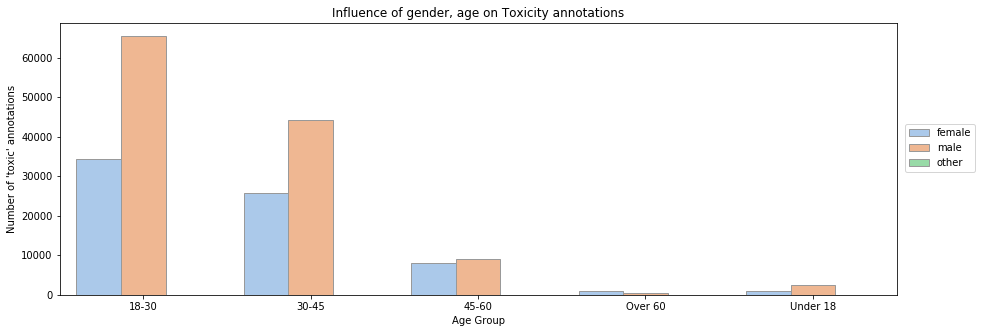

In [87]:
plt.figure(figsize=(15,5))
ax = sns.barplot(y="toxicity", hue="gender", x="age_group",
            palette="pastel", edgecolor=".6",
            data=df_age_gender)
ax.set(ylabel = "Number of 'toxic' annotations", xlabel = 'Age Group')
ax.set_title("Influence of gender, age on Toxicity annotations")

plt.legend(bbox_to_anchor=(1.01, 0.63), loc=2, borderaxespad=0.)

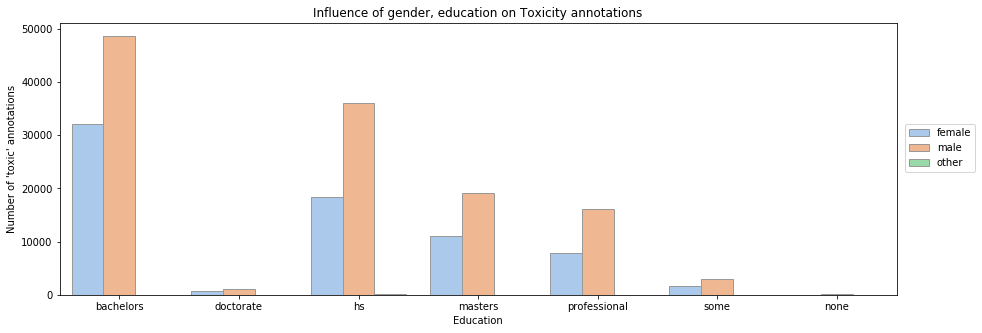

In [88]:
plt.figure(figsize=(15,5))
ax = sns.barplot(y="toxicity", hue="gender", x="education",
            palette="pastel", edgecolor=".6",
            data=df_edu_gender)
ax.set(ylabel = "Number of 'toxic' annotations", xlabel = 'Education')
ax.set_title("Influence of gender, education on Toxicity annotations")
plt.legend(bbox_to_anchor=(1.01, 0.63), loc=2, borderaxespad=0.)


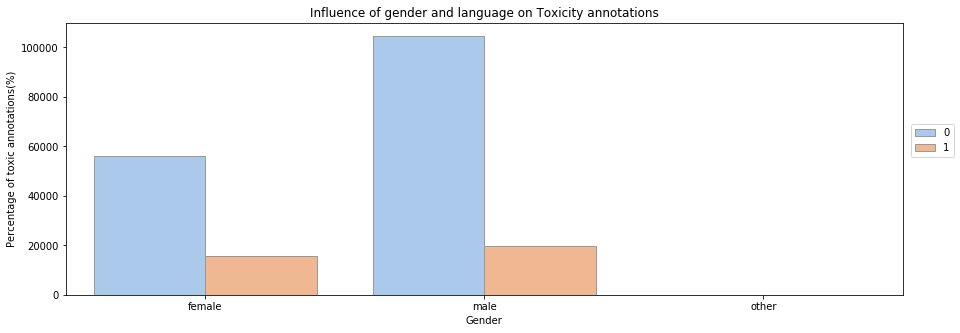

In [86]:
df_gender = df.groupby(['gender', 'english_first_language'], as_index = False).agg({'toxicity':'sum', 'rev_id':'count'})
df_gender['toxic_annotations_percent'] = (df_age_gender['toxicity'] / df_age_gender['rev_id'])*100

plt.figure(figsize=(15,5))
ax = sns.barplot(y="toxicity", hue="english_first_language", x="gender",
            palette="pastel", edgecolor=".6",
            data=df_gender)
ax.set(ylabel = "Percentage of toxic annotations(%)", xlabel = 'Gender')
ax.set_title("Influence of gender and language on Toxicity annotations")

plt.legend(bbox_to_anchor=(1.01, 0.63), loc=2, borderaxespad=0.)

#### Identify most speech characteristics associated to toxicit

In this section we find the keywords most associated with toxic comments, to understand it's text characteristics.

To normalize the bias from worker demographic, we will subset the comments data for only those comments that are tagged as 'toxic' by more than 50% of the annotators. This will give us a relatively bias-free insight into the text characteristics.

In [16]:
# labels a comment as toxic if the majority of annoatators did so
labels = t_annotations.groupby('rev_id', as_index = False)['toxicity'].mean()
labels['toxic_flag'] = 'False'

labels.loc[labels['toxicity'] > 0.5, 'toxic_flag'] = 'True'

Add the new derived tocicity_flag to the comments table and subset only the toxic comments

In [17]:
t_comments['toxic_flag'] = labels['toxic_flag']

toxic = t_comments[t_comments['toxic_flag']== 'True']
toxic.head(5)

,rev_id,comment,year,logged_in,ns,sample,split,toxic_flag
82,597212.0,`NEWLINE_TOKENNEWLINE_TOKENAfter the wasted bi...,2003,False,article,random,test,True
211,1266286.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2003,True,user,random,test,True
245,1502668.0,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",2003,True,user,blocked,test,True
334,2187425.0,```Nazi filth`` is impolite NEWLINE_TOKENNEWL...,2004,True,article,random,train,True
483,3129678.0,"Prior to Quickpolls, he would have been perma...",2004,True,user,random,train,True


Clean the data by removing unwanted strings from the comments

In [18]:
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("TOKEN", ""))
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("TAB_TOKEN", ""))
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("NEWLINE", ""))
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("_", ""))
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("==", ""))
toxic['comment'] = toxic['comment'].apply(lambda x: x.replace("===", ""))

C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [19]:
toxic.head()

,rev_id,comment,year,logged_in,ns,sample,split,toxic_flag
82,597212.0,"`After the wasted bit on his sexuality, I have...",2003,False,article,random,test,True
211,1266286.0,"Erik, for crying out loud. You legally can hav...",2003,True,user,random,test,True
245,1502668.0,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",2003,True,user,blocked,test,True
334,2187425.0,```Nazi filth`` is impolite `,2004,True,article,random,train,True
483,3129678.0,"Prior to Quickpolls, he would have been perma...",2004,True,user,random,train,True


Here we use the <b>nltk</b> package to tokenize and tag the comments inorder to identify and extract nouns, verbs and adjectives from the text present in the data.

We will then get the most frequent keywords associated with toxicity, using the 'Counter' function from the <b>collections</b> package.

In [27]:
tokens = pos_tag_sents(toxic["comment"].apply(word_tokenize).tolist())

The above code returns a list of touples containing the words and their corresponding pos_tag. \
For eg: 
[('Rome','NN'), ('beautiful','JJ')]

We will subset the nouns and adjectives from each text as these are most likely to be the keywords associated to toxicity.

In [38]:

words = []
for rows in tokens:
    r = [t[0] for t in rows if t[1] in ['NNP', 'NN', 'JJ']]
    words.append(r)

In [39]:
#Flatten the sublists into a single list
words_flat = [item for sublist in words for item in sublist]

len(words_flat)

317070

In [66]:
# Counting the most frequent words (atleast 1000 occurances) in the toxic comments
words_flat = [x.lower() for x in words_flat]
keywords = Counter(words_flat).most_common(1000)

toxicity_keywords_df = pd.DataFrame(keywords[0:20], columns =['Keyword', 'Count']) 

In [67]:
toxicity_keywords_df['total_comments'] = len(toxic['comment'])
toxicity_keywords_df['Frequency(%)'] = (toxicity_keywords_df['Count']/toxicity_keywords_df['total_comments'])*100

#List of unwanted words that might pass through the pos_tag filter
stopwords = ['you', 'my', 'i', 'u', 'a']

toxicity_keywords_df_clean = toxicity_keywords_df[~toxicity_keywords_df['Keyword'].isin(stopwords)]

Ploting the most associated keywords to toxicity

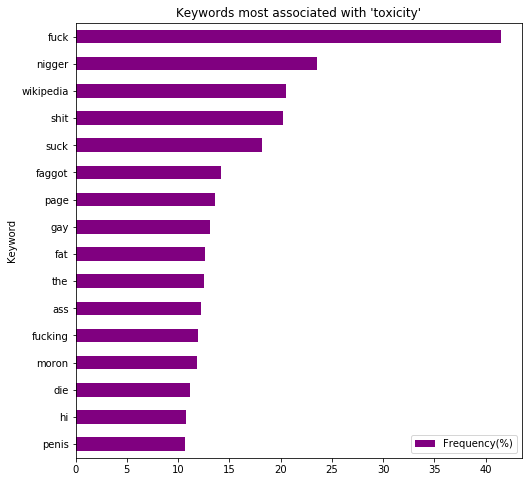

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
toxicity_keywords_df_clean.sort_values(by='Frequency(%)').plot.barh(x='Keyword',
                      y='Frequency(%)',
                      ax=ax,
                      color="purple")

ax.set_title("Keywords most associated with 'toxicity'")

plt.show()

#### Comparative analysis of speech characteristics between toxicity and personal-attacks


In this section we find the keywords most associated with personal attacks, to understand it's text characteristics and compare them with the characteristics of the 'toxicity' dataset.

To normalize the bias from worker demographic, we will subset the comments data for only those comments that are tagged as 'personal attack' by more than 50% of the annotators. This will give us a relatively bias-free insight into the text characteristics.

All the following steps are similar to the ones performed for identifying the keywords for toxicity in the previous section.

In [90]:
# labels a comment as toxic if the majority of annoatators did so
labels = a_annotations.groupby('rev_id', as_index = False)['attack'].mean()
labels['attack_flag'] = 'False'

labels.loc[labels['attack'] > 0.5, 'attack_flag'] = 'True'

In [91]:
a_comments['attack_flag'] = labels['attack_flag']

attack = a_comments[a_comments['attack_flag']== 'True']
attack.head(5)

,rev_id,comment,year,logged_in,ns,sample,split,attack_flag
60,801279,Iraq is not good ===NEWLINE_TOKENNEWLINE_TO...,2003,False,article,random,train,True
207,2702703,NEWLINE_TOKENNEWLINE_TOKEN____NEWLINE_TOKENfuc...,2004,False,user,random,train,True
351,4632658,"i have a dick, its bigger than yours! hahaha",2004,False,article,blocked,train,True
492,6545332,NEWLINE_TOKENNEWLINE_TOKEN== renault ==NEWLINE...,2004,True,user,blocked,train,True
493,6545351,NEWLINE_TOKENNEWLINE_TOKEN== renault ==NEWLINE...,2004,True,user,blocked,test,True


In [92]:
attack['comment'] = attack['comment'].apply(lambda x: x.replace("TOKEN", ""))
attack['comment'] = attack['comment'].apply(lambda x: x.replace("TAB_TOKEN", ""))
attack['comment'] = attack['comment'].apply(lambda x: x.replace("NEWLINE", ""))
attack['comment'] = attack['comment'].apply(lambda x: x.replace("_", ""))
attack['comment'] = attack['comment'].apply(lambda x: x.replace("==", ""))
attack['comment'] = attack['comment'].apply(lambda x: x.replace("===", ""))

C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Frost\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [94]:
att_tokens = pos_tag_sents(attack["comment"].apply(word_tokenize).tolist())


In [95]:
a_words = []
for rows in att_tokens:
    r = [t[0] for t in rows if t[1] in ['NNP', 'NN', 'JJ']]
    a_words.append(r)

#Flatten the sublists into a single list
awords_flat = [item for sublist in a_words for item in sublist]

len(awords_flat)

348325

In [96]:
# Counting the most frequent words (atleast 1000 occurances) in the attack comments
awords_flat = [x.lower() for x in awords_flat]
attack_keywords = Counter(awords_flat).most_common(1000)

attack_keywords_df = pd.DataFrame(attack_keywords[0:20], columns =['Keyword', 'Count']) 

In [101]:
attack_keywords_df['total_comments'] = len(attack['comment'])
attack_keywords_df['Frequency(%)'] = (attack_keywords_df['Count']/attack_keywords_df['total_comments'])*100

#List of unwanted words that might pass through the pos_tag filter
stopwords = ['you', 'my', 'i', 'u', 'a'] #same as used for toxicity

attack_keywords_df_clean = attack_keywords_df[~attack_keywords_df['Keyword'].isin(stopwords)]


Plotting the keywords for both the datasets for comparison

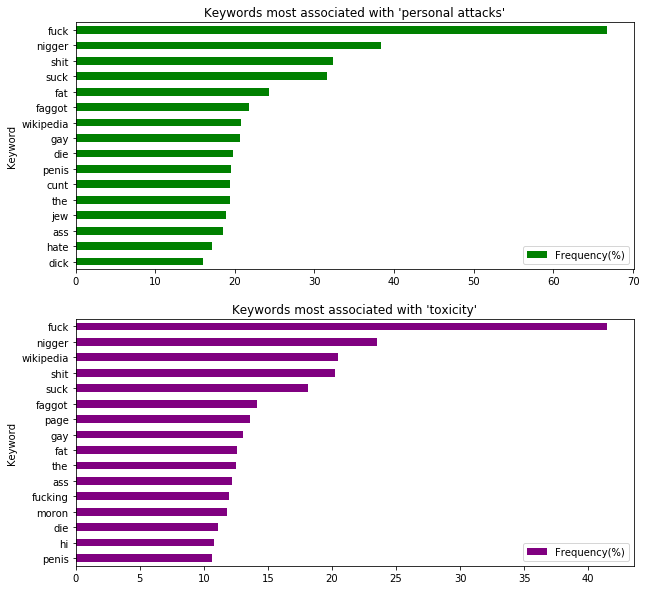

In [109]:

fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 10))

# Plot horizontal bar graph
attack_keywords_df_clean.sort_values(by='Frequency(%)').plot.barh(x='Keyword',
                      y='Frequency(%)',
                      ax=ax1,
                      color="green")

ax1.set_title("Keywords most associated with 'personal attacks'")



# Plot horizontal bar graph
toxicity_keywords_df_clean.sort_values(by='Frequency(%)').plot.barh(x='Keyword',
                      y='Frequency(%)',
                      ax=ax2,
                      color="purple")

ax2.set_title("Keywords most associated with 'toxicity'")

plt.show()